In [1]:
# Install all the missing libraries
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install torch
!pip install nltk
!pip install gensim
!pip install tqdm
!pip install fasttext
!pip install pyLDAvis
!pip install bokeh
!pip install wordcloud
!pip install spacy
!pip install ipywidgets

You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics

You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/home/olivier/git/datapop/covidTopics/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
from dataPreprocessing import preProcessing

In [4]:
import os
import re
from tqdm.auto import tqdm
import requests

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

In [6]:
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

In [7]:
#from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import spacy

In [8]:
#from fasttext import fasttext
from gensim.models.fasttext import FastText
#from fasttext import util
#util.download_model('es', if_exists='ignore')  # English
#model = fasttext.load_model('./models/pretrained/fasttext/cc.es.300.bin') # Pass location of the downloaded bin file

In [9]:
# Load the pretrained fasttext model in Spanish
PRETRAINED_FASTTEXT_MODEL = './models/lid.176.bin'

In [10]:
# Download pre-trained Fasttext model to us in language detection
#!wget -O ./models/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

In [11]:
# Load data
df = pd.read_csv('./data/Tweets_Activity_Week5_VOX_All_Tweets_O_utf.txt', header=None)
# Rename the column
df.columns = ['original_txt']
df.shape

(210713, 1)

In [12]:
df.head(10)

,original_txt
0,@anguestar @ecd_ Son peligrosos que no es lo mismo.
1,No lo hace el PP lo hacéis vosotros solitos. https://t.co/BSR9ht52CV
2,"@ecd_ No lo hace el PP, lo hacéis vosotros solitos."
3,La historia se repite. Socialismo+comunismo+ nacionalismo. https://t.co/l4xKV2zpXq
4,@okdiario Si claro. Eso dicen en Cuba también.
5,@okdiario Si lo vimos ayer. Son unos jetas.
6,@okdiario Pero en esa foto va maquillada y de nota un huevo además... ?¿
7,@okdiario Normal. ??Yo como ciudadana también.
8,@okdiario Estados unidos tiene 328 millones de habitantes.
9,@okdiario A buenas horas. Que se piren.


# Data preparation

Before doing the analysis, we need to preprocess the text. 
First we will remove the URL, Mentions and hashtag symbol that are specific to Twitter but should not be part of the clustering.
Second we will detect in which language the tweets are. We are only interested in Spanish tweets [INSERT REASON OTHER THAN - EASIER], therefore we have to exclude tweets that are not in Spanish. 
Doing it manually it is impossible, we rely on the fasstext library to detect languages and select the ones that we can be confident enough they are in Spanish.

However, the specificity of Twitter is to be comprise of Hashtags, Mentions and URLs. These entities carry information but are not useful directly for the topic identification.
We have to then remove the tweets that are only containing such entities without text to analyse. 

# Checking if tweets contains valuable text


In [13]:
# Need to check the URL to see the full one: 
def resolve_url(url):
    try:
        res = urllib2.urlopen(url)
        print(res)
        return res.geturl()
    except:
        return 'InvalidURL'

In [14]:
# Searching and replacing all mentions, urls and hashtags found but keep them in new columns
df[['clean_txt', 'mentions', 'urls', 'hashtags', 'rt_status']] = pd.DataFrame(df['original_txt'].apply(preProcessing.preprocess_tweet).tolist())

In [15]:
df['raw_word_count'] = df['original_txt'].apply(lambda x: len(str(x).split(" ")))

In [16]:
df['clean_txt'] = df['clean_txt'].str.replace('MENTION', '').replace('URL', '').replace('HASHTAG', '')

In [17]:
df['clean_word_count'] = df['clean_txt'].apply(lambda x: len(str(x).split(" ")))

In [18]:
# Removing all the entries that have a size less than 10 after cleaning text
#df = df[df['word_count'] > 10]

In [19]:
print("Word Count Median: " + str(df['clean_word_count'].median()))
print(df['clean_word_count'].describe())

Word Count Median: 10.0
count    210713.000000
mean         13.838420
std          11.805826
min           1.000000
25%           5.000000
50%          10.000000
75%          19.000000
max          91.000000
Name: clean_word_count, dtype: float64


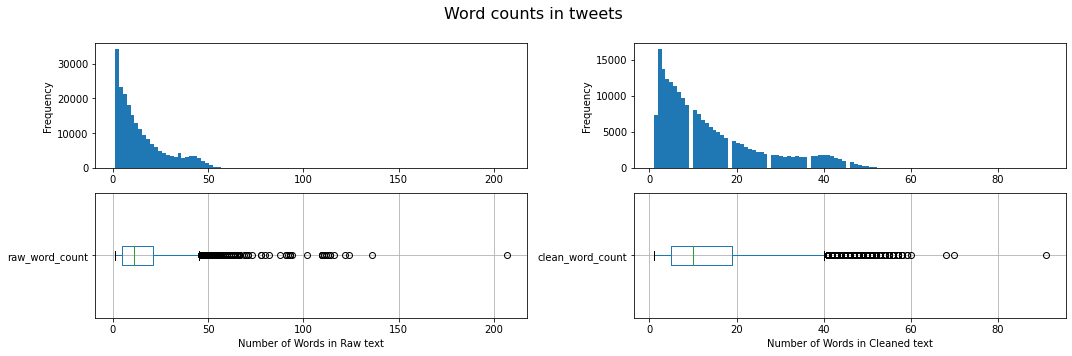

In [20]:
n_bins = 100


fig = plt.figure(figsize=(15,5))
fig.suptitle("Word counts in tweets ", fontsize=16)


plt.subplot(2, 2, 1)

plt.hist(df['raw_word_count'], bins=n_bins)
plt.ylabel('Frequency')


plt.subplot(2, 2, 2)

plt.hist(df['clean_word_count'], bins=n_bins)
plt.ylabel('Frequency')


plt.subplot(2, 2, 3)

df['raw_word_count'].to_frame().boxplot(vert=False)
plt.xlabel('Number of Words in Raw text')


plt.subplot(2, 2, 4)

df['clean_word_count'].to_frame().boxplot(vert=False)
plt.xlabel('Number of Words in Cleaned text')


fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.savefig("./plots/word_counts.svg", format="svg")
plt.show()


## Frequency count on the entities

In [21]:
def flatten_list(entities):
    return [item for sublist in entities for item in sublist]

### Mentions
Who are the most often mentioned accounts

In [22]:
mentions = pd.Series(flatten_list(df['mentions']))

mentions.value_counts().describe()

count    63763.000000
mean         4.051488
std         28.200489
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       3203.000000
dtype: float64

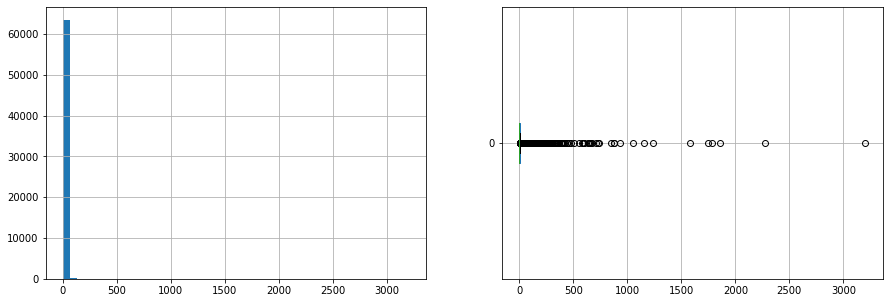

In [23]:
fig = plt.figure(figsize=(15,5))

plt.title('Frequencies of mentions')

plt.subplot(1, 2, 1)
# Create bars
mentions.value_counts().hist(bins=50)
plt.subplot(1, 2, 2)
mentions.value_counts().to_frame().boxplot(vert=False)

plt.show()

In [24]:
Q1 = np.percentile(mentions.value_counts(), 1, interpolation = 'midpoint') 

Q25 = np.percentile(mentions.value_counts(), 25, interpolation = 'midpoint') 
  
Q75 = np.percentile(mentions.value_counts(), 75, interpolation = 'midpoint') 

Q99 = np.percentile(mentions.value_counts(), 99, interpolation = 'midpoint') 
  
# Interquaritle range (IQR) 
IQR = Q75 - Q25
  
print("Q1: {} - Q25: {} - Q75: {} - Q99: {}".format(Q1, Q25, Q75, Q99))

Q1: 1.0 - Q25: 1.0 - Q75: 3.0 - Q99: 37.0


In [25]:
df_mentions = mentions.value_counts().to_frame().reset_index()
df_mentions.columns = ["mentions", 'count']

In [26]:
df_mentions.head(50)

,mentions,count
0,psoe,3203
1,sanchezcastejon,2273
2,vox_es,1862
3,pabloiglesias,1785
4,santi_abascal,1746
5,pnique,1583
6,guardiacivil,1242
7,podemos,1155
8,_anapastor_,1048
9,alvisepf,928


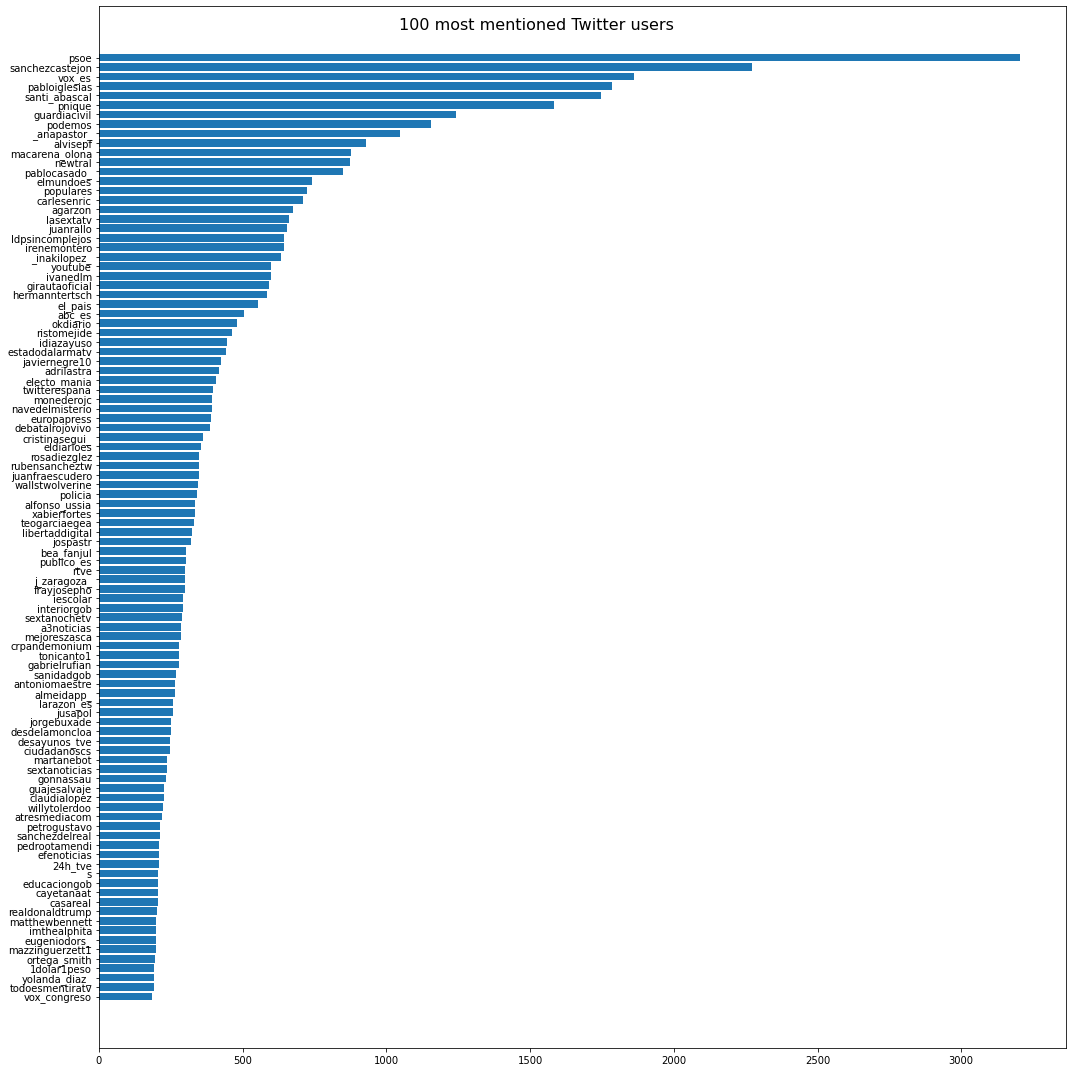

In [27]:
x = df_mentions['mentions'].head(100)
y = df_mentions['count'].head(100)
fig, ax = plt.subplots(figsize=(15, 15))
fig.suptitle('100 most mentioned Twitter users', fontsize=16)

plt.barh(x, y)
ax.invert_yaxis()
#plt.xticks(rotation=90)
plt.tight_layout()
#plt.axis('off')

#plt.grid(None)
plt.show()

### URLS

In [28]:
# Need the tweet object to find which URL they share

In [29]:
# Parsing them and create a dictionary with original: resolved.
# Then check if several point to the same resolved url
# If 

In [30]:
urls = pd.Series(flatten_list(df['urls']))

urls.value_counts().describe()

count    66910.000000
mean         1.029562
std          0.543708
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         94.000000
dtype: float64

In [31]:
df_urls = urls.value_counts().to_frame().reset_index()
df_urls.columns = ["urls", 'count']

In [32]:
# Need to check the URL to see the full one: 
def resolve_url(url):
    try:
        resp = requests.head(url, allow_redirects=True)
    #return resp.status_code
        return resp.url
    except:  # FIXME it is only temporarly because the function is useless right now anyway
        return 'InvalidURL'
    #return resp.headers["Location"]

#session = requests.Session()  # so connections are recycled
#resp = session.head(url, allow_redirects=True)
#print(resp.url)

In [33]:
#df_urls['unshorten_url'] = df_urls['urls'].apply(resolve_url)

### Hashtags

In [34]:
hashtags = pd.Series(flatten_list(df['hashtags']))

hashtags.value_counts().describe()

count    6486.000000
mean        6.789855
std       127.553017
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max      8833.000000
dtype: float64

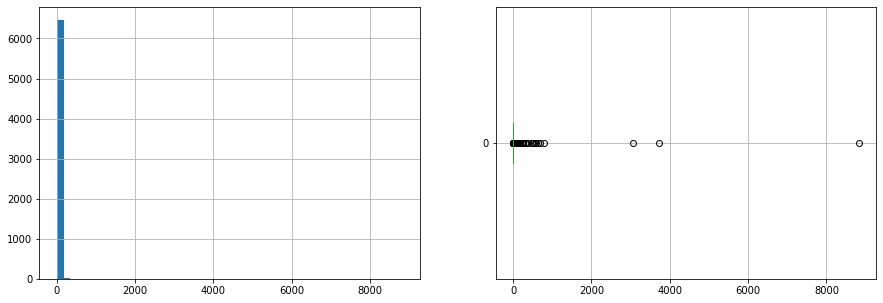

In [35]:
fig = plt.figure(figsize=(15,5))

plt.title('Frequencies of hashtags')

plt.subplot(1, 2, 1)
# Create bars
hashtags.value_counts().hist(bins=50)
plt.subplot(1, 2, 2)
hashtags.value_counts().to_frame().boxplot(vert=False)

plt.show()

In [36]:
df_hashtags = hashtags.value_counts().to_frame().reset_index()
df_hashtags.columns = ["hashtags", 'count']

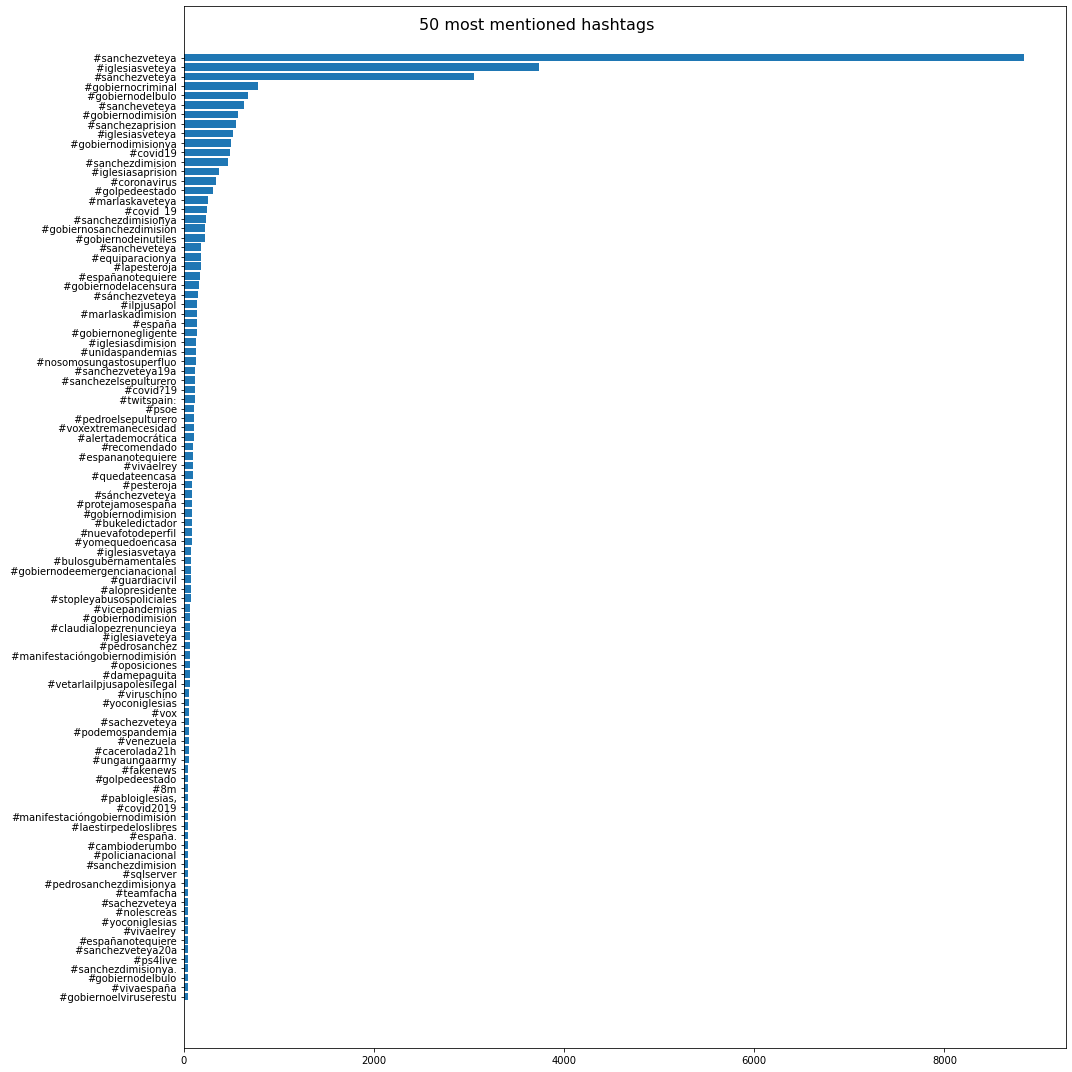

In [37]:
x = df_hashtags['hashtags'].head(100)
y = df_hashtags['count'].head(100)
fig, ax = plt.subplots(figsize=(15, 15))
fig.suptitle('50 most mentioned hashtags', fontsize=16)

plt.barh(x, y)
ax.invert_yaxis()
#plt.xticks(rotation=90)
plt.tight_layout()
#plt.axis('off')

#plt.grid(None)
plt.show()

## Filter the language

In [38]:
#model = FastText.load_model(PRETRAINED_FASTTEXT_MODEL)
#model = FastText.load_facebook_model(PRETRAINED_FASTTEXT_MODEL)

In [39]:
import fasttext
model = fasttext.load_model(PRETRAINED_FASTTEXT_MODEL)

In [40]:
# Source: https://amitness.com/2019/07/identify-text-language-python/
def get_lang(txt, lang_detector):
    try:
        label, proba = lang_detector(txt)

        if len(label) == 1:  # Only one language detected
            label = label[0].replace('__label__', '')
            proba = proba[0]
        elif len(label) >1:  # Several language detected
            label = 'multilangue'
            proba = np.mean(proba)  # Get the mean of the proba as not interested in it
        
    except Exception as e:
        label, proba = None, None
    return label, proba

In [41]:
# Run fasttext to detect language and unpack the tuple (label and proba) 
# into respective colums
df[['lang_label', 'lang_proba']] = pd.DataFrame(df['clean_txt'].apply(get_lang,args=(model.predict,)).tolist())

We should first remove all the tweets that have a language different than Spanish with a probability higher than 0.6 (arbitrary threshold).
Then we will remove all the tweets that 

In [42]:
# Check how many tweets have a lang_proba higher than 0.5 and are not considered as 'es'
#df[(df['lang_proba'] > 0.6) & ~(df['lang_label'].isin(['es']))]#[['lang', 'lang_label', 'text', 'cleaned_txt']]

In [43]:
# Check how many tweets have a lang_proba higher than 0.5 and are not considered as 'es' or 'ca'
#df[(df['lang_proba'] < 0.5)]#[['lang', 'lang_label', 'text', 'cleaned_txt']]

In [44]:
df_preprocess = df[(df['lang_proba'] > 0.6) & (df['lang_label'].isin(['es'])) & (df['clean_word_count'] > 5)].reset_index()

In [45]:
df_preprocess = df_preprocess.rename(columns = {'index':'original_index'})

In [46]:
## Tokenize the tweets

In [52]:
word_tokenized_corpus = df_preprocess['clean_txt']

## LDA Implementation

Source: 
1. https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
1. https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
1. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [53]:
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim import corpora 
import gensim

In [54]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [55]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a='auto', eta='None'):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=eta,
                                           per_word_topics=True, 
                                           workers=3)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [56]:
docs = word_tokenized_corpus

In [57]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(docs, min_count=5)#, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

NameError: name 'data_words_nostops' is not defined

In [58]:
# Compute bigrams.
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=5)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)


In [59]:
id2word = corpora.Dictionary(word_tokenized_corpus)
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
#id2word.filter_extremes(no_below=20, no_above=0.5)
corpus = [id2word.doc2bow(text) for text in word_tokenized_corpus]

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [ ]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = [#'75% Corpus', 
                '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run

pbar = tqdm(total=540)
    
# iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, etan=b)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
pd.DataFrame(model_results).to_csv('./lda_tuning_results.csv', index=False)
pbar.close()

In [ ]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
topics_range = range(min_topics, max_topics, 1)
# Validation sets
num_of_docs = len(corpus)

model_results = {'Topics': [],  'Coherence': []}

# Can take a long time to run

pbar = tqdm(total=len(topics_range))
    

# iterate through number of topics
for k in topics_range:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=k, random_state=100,update_every=1,
                                                chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        
    coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='c_v')
    
    cv = coherence_model_lda.get_coherence()
    # Save the model results
    model_results['Validation_Set'].append(corpus_title[i])
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)
                    
    pbar.update(1)
pd.DataFrame(model_results).to_csv('./lda_tuning_results.csv', index=False)
pbar.close()

In [ ]:
lda_model.print_topics()


In [ ]:
# Build LDA model
NUM_TOPICS = 10

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=NUM_TOPICS, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

## Visualisation of LDA

Source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [ ]:
import matplotlib.colors
cols = [color for name, color in matplotlib.colors.TABLEAU_COLORS.items()] 

In [ ]:
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

 ### Dominant topic and its percentage contribution in each document

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=word_tokenized_corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

### Most representative sentence for each topic

In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

### Frequency Distribution of Word Counts in Documents

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,14))
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [ ]:
import seaborn as sns


fig, axes = plt.subplots(2,2,figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 60, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 60), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,60,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [ ]:
# 1. Wordcloud of Top N words in each topic
from wordcloud import WordCloud

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(2, 5, figsize=(16,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in word_tokenized_corpus for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### t-SNE Clustering Chart

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

In [ ]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

# Elbow method may find a better viz

In [ ]:
X =  ft_model.wv.vectors_vocab
max_cluster = 25
distortions = []
for i in range(1, max_cluster):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, max_cluster), distortions, marker='o')
plt.vlines(range(1, max_cluster), min(distortions), distortions, linestyle="dashed", color='grey')
plt.xticks(range(0, max_cluster+1))
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=10
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

In [ ]:
from sklearn.cluster import KMeans 

from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
#print (labels)
print(len(labels))
print ("Centroids data")
#print (centroids)
print(len(centroids))